# Causality in Practice

## An Illustration

### Setup

First we import standard libraries.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from dowhy import gcm
from causallearn import graph

We then define a helper function for visualization.

In [2]:
from IPython.display import Image, display
from causallearn.utils.GraphUtils import GraphUtils

def view_pydot(g,labels):
    pdot = GraphUtils.to_pydot(g,labels=labels)
    plt = Image(pdot.create_png())
    display(plt)

### Data generation

We generate data from a synthetic functions model made up of three variables:
- GDP: gross domestic product;
- Adv: investment in advertising car model C;
- Car: sales of car C;
- Law: level of penalties for thefts;
- Theft: number of thefts.

**DISCLAIMER(1)**: the model and its function are absolutely fictional, created only for the purpose of this example.

**DISCLAIMER(2)**: interpretation of the model would probably be more meaningful with a Gini index instead of GDP.

In [3]:
n_samples = 1000000

GDP = np.random.normal(loc=5, scale=1, size=n_samples)

Adv = np.random.normal(loc=0, scale=1, size=n_samples)
Car = 10 * GDP**2 + Adv + np.random.normal(loc=0, scale=1, size=n_samples)

Law = np.random.normal(loc=0, scale=1, size=n_samples)
Theft = 5 * GDP/2 + Law + np.random.normal(loc=0, scale=2, size=n_samples)

data = pd.DataFrame(dict(GDP=GDP, Adv=Adv, Car=Car, Law=Law, Theft=Theft))
labels = [f'{col}' for i, col in enumerate(data.columns)]

car = Car.reshape(-1,1)
theft = Theft.reshape(-1,1)

Let us look at the data.

In [4]:
data

,GDP,Adv,Car,Law,Theft
0,4.668847,-0.529626,217.179587,-0.655219,11.855366
1,3.920379,-0.468415,153.249123,-0.806498,7.655897
2,4.643784,1.217185,218.079620,-0.756441,11.683707
3,3.755040,-0.016659,140.393719,0.286173,10.308470
4,5.224212,0.602634,273.705032,-0.136135,15.646309
...,...,...,...,...,...
999995,5.423970,-0.083330,294.973735,1.702337,16.807425
999996,5.458921,1.063761,299.503332,-0.703097,13.325459
999997,4.722405,-0.477566,221.805086,2.101157,15.113185
999998,4.673321,-0.205452,217.297846,0.045715,10.620284


### Data analysis

Let us do a simple analysis by computing correlations.

In [5]:
c = data.corr()
c.style.background_gradient(cmap='coolwarm')

,GDP,Adv,Car,Law,Theft
GDP,1.000000,0.001587,0.990063,-0.000338,0.745100
Adv,0.001587,1.000000,0.011545,0.000019,0.001863
Car,0.990063,0.011545,1.000000,-0.000351,0.737634
Law,-0.000338,0.000019,-0.000351,1.000000,0.297068
Theft,0.745100,0.001863,0.737634,0.297068,1.000000


And let us plot the variable we really care about (*Theft*) wrt another highly-correlated easily-controllable variable (*Car*).

Text(0, 0.5, 'Theft')

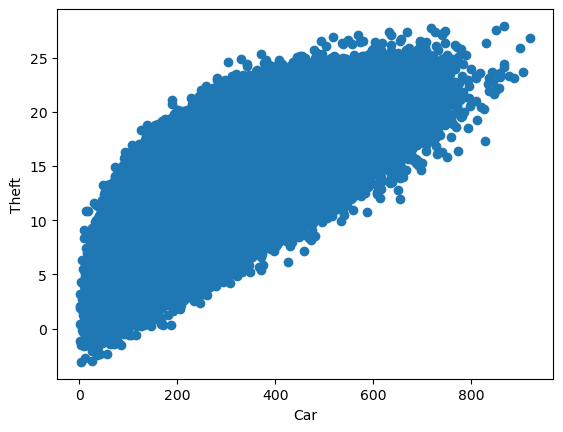

In [6]:
plt.scatter(car,theft)
plt.xlabel('Car')
plt.ylabel('Theft')

### Modelling

Let us fit a very simple model to the data.

Text(0, 0.5, 'Theft')

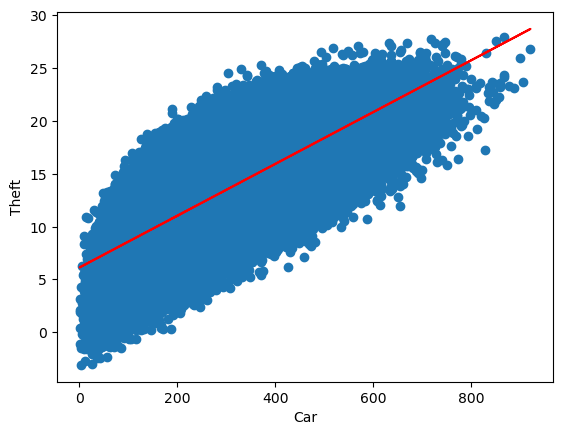

In [7]:
import sklearn.linear_model as lm
model = lm.LinearRegression().fit(car,theft)
plt.plot(car, model.predict(car), color='r')
plt.scatter(car,theft); plt.xlabel('Car'); plt.ylabel('Theft')

### Testing

Let us evaluate our model. First we generate new testing data.

In [8]:
n_samples = 500

GDP = np.random.normal(loc=5, scale=1, size=n_samples)

Adv = np.random.normal(loc=0, scale=1, size=n_samples)
Car = 10 * GDP**2 + Adv + np.random.normal(loc=0, scale=1, size=n_samples)

Law = np.random.normal(loc=0, scale=1, size=n_samples)
Theft = 5 * GDP/2 + Law + np.random.normal(loc=0, scale=2, size=n_samples)

testdata = pd.DataFrame(dict(GDP=GDP, Adv=Adv, Car=Car, Law=Law, Theft=Theft))

test_car = Car.reshape(-1,1)
test_theft = Theft.reshape(-1,1)

Let us look at the test data.

In [9]:
testdata

,GDP,Adv,Car,Law,Theft
0,6.666433,1.478947,445.409337,1.000845,18.829330
1,4.840353,0.379698,234.169937,1.063384,13.177976
2,4.028298,1.003980,161.244945,0.557064,12.157805
3,4.344177,0.224752,189.139872,1.137787,13.588219
4,6.046938,0.692811,365.905214,-0.902937,14.825151
...,...,...,...,...,...
495,4.012369,-0.957046,160.768626,-1.359120,7.746612
496,4.657226,-0.655041,216.021114,-0.259421,11.694261
497,3.694670,0.012812,136.385737,0.716259,12.270873
498,5.173866,-0.465759,268.045064,0.544267,12.387138


Let us process the test data with our model and computed MSE.

In [10]:
import sklearn.metrics as metrics
print(metrics.mean_squared_error(model.predict(test_car), test_theft))

5.283402750521736


### Control

Let us now try to control the quantity we care about (*Theft*) by looking at our learned model and trying to force the value of car sales (*Car*) to zero. Let us collect data corresponding to this scenario.

In [11]:
n_samples = 500

GDP = np.random.normal(loc=5, scale=1, size=n_samples)

Adv = np.random.normal(loc=0, scale=1, size=n_samples)
Car = np.zeros(n_samples)

Law = np.random.normal(loc=0, scale=1, size=n_samples)
Theft = 5 * GDP/2 + Law + np.random.normal(loc=0, scale=2, size=n_samples)

intervdata = pd.DataFrame(dict(GDP=GDP, Adv=Adv, Car=Car, Law=Law, Theft=Theft))

interv_car = Car.reshape(-1,1)
interv_theft = Theft.reshape(-1,1)

Let us apply our model the new interventional data and compute MSE.

In [12]:
print(metrics.mean_squared_error(model.predict(interv_car), interv_theft))

55.4735816329403


Let us look at the data to understand what happened.

Text(0, 0.5, 'Theft')

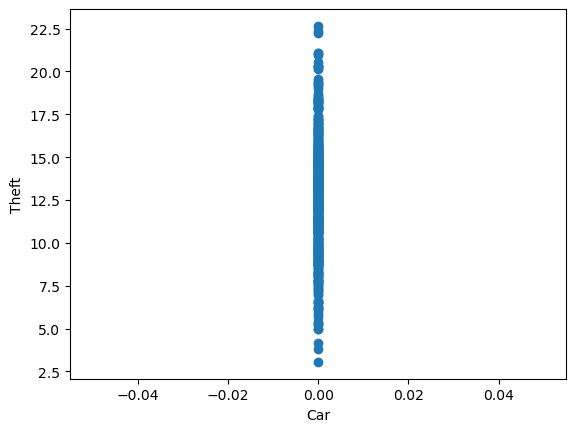

In [13]:
plt.scatter(interv_car,interv_theft)
plt.xlabel('Car')
plt.ylabel('Theft')

### Causal discovery

Let us use *causal_learn* to infer the underlying causal graph

  0%|          | 0/5 [00:00<?, ?it/s]

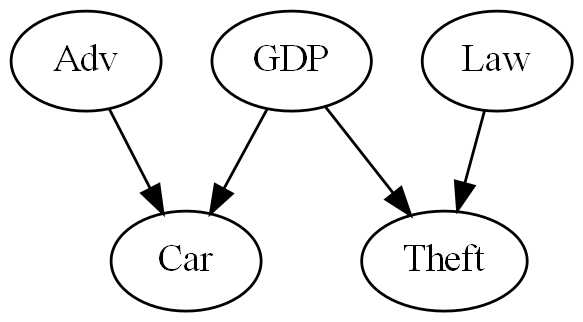

In [14]:
from causallearn.search.ConstraintBased.PC import pc

graph = pc(np.array(data))
view_pydot(graph.G,labels)

## Discussion

Let us explore some limitations of this approach.

### Issue 1: Statistical power

We need enough data to perform causal discovery.

  0%|          | 0/5 [00:00<?, ?it/s]

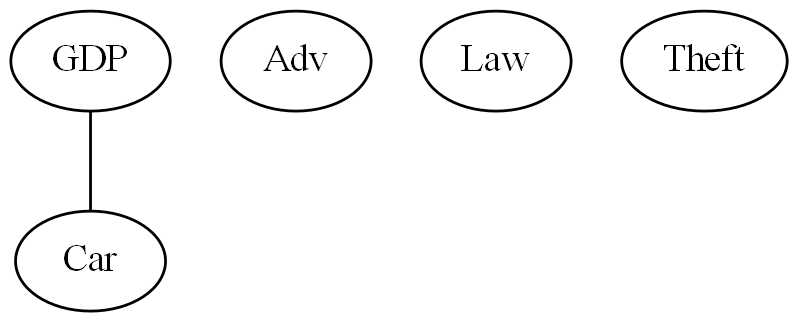

In [15]:
graph = pc(np.array(data[0:50]))
view_pydot(graph.G,labels)

### Issue 2: Statistical hyperparameters / Different algorithms

We need to choose proper algorithm and proper hyperparameters.

  0%|          | 0/5 [00:00<?, ?it/s]

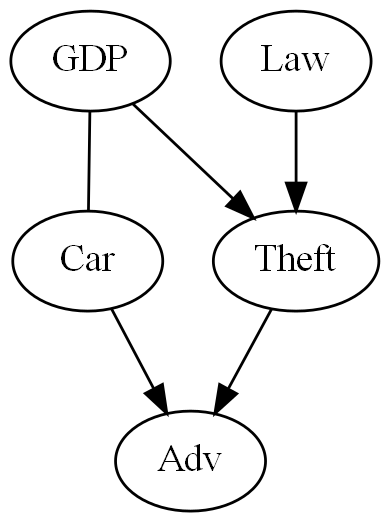

In [16]:
graph = pc(np.array(data),alpha=.4)
view_pydot(graph.G,labels)

## Issue 3: No sufficiency (hidden confounders)

We need to meet the assumptions of the chosen algorithm.

  0%|          | 0/4 [00:00<?, ?it/s]

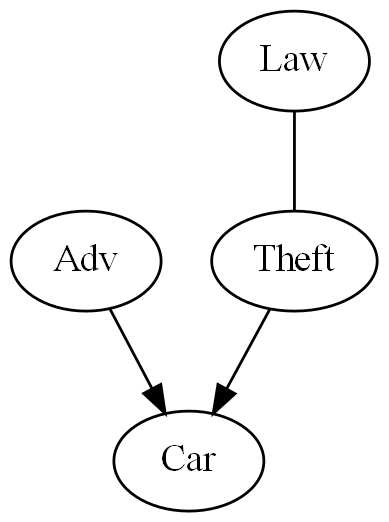

In [18]:
graph = pc(np.array(data)[:,1:])
view_pydot(graph.G,labels=labels[1:])

### Issue 4: Data ordering

We need to be aware of the properties of the algorithm.

  0%|          | 0/5 [00:00<?, ?it/s]

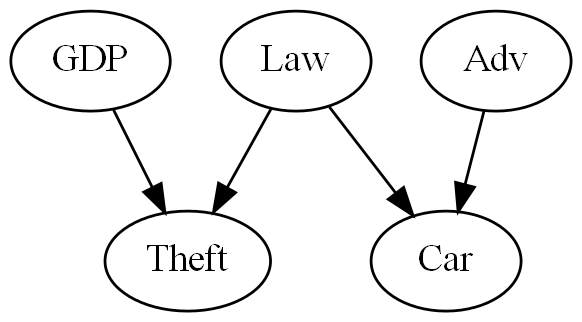

In [19]:
newdata = data[['Adv', 'Law', 'Theft', 'GDP', 'Car']]
graph = pc(np.array(newdata))
view_pydot(graph.G,labels=labels)

## Conclusion

We may want to reason *causally* and perform *causal discovery* in order to better understand our system and control it effectively. However, causal discovery is not trivial, and, as highlighted by the issues discussed above, there is no immediate out-of-the-shelf way to do it.

**DISCLAIMER**: This example is not meant to be flatly repeated in any possible situation!